# Pulsebuilding for QCoDeS part III

One concrete example of building pulses and uploading them to an AWG.

In [1]:
%matplotlib nbagg
import numpy as np

import qcodes.instrument_drivers.tektronix.pulsebuilding as pb
import qcodes.instrument_drivers.tektronix.AWG5014 as AWG

ramp = pb.PulseAtoms.ramp
sine = pb.PulseAtoms.sine
gauss = pb.PulseAtoms.gaussian

In [2]:
awg = AWG.Tektronix_AWG5014('AWG1', 'TCPIP0::192.168.15.113::inst0::INSTR', timeout=40)

Connected to: TEKTRONIX AWG5014C (serial:B051039, firmware:SCPI:99.0 FW:4.6.0.7) in 0.12s


In [3]:
# Prepare the AWG for what is to come
awg.ch1_amp(2)
awg.ch3_amp(2)
awg.clock_freq(1e9)

In [8]:
# Since compiling an .awg file requires knowledge of the full internal state of an AWG instrument, only the instrument
# itself can do that. The pulse building library provides easy interfacing with the QCoDeS AWG5014 driver.

# NOTE: This example uses REAL units. 

# First we make some basic pulses
sawtooth = pb.BluePrint([ramp, ramp, ramp],
                        [(1e4, 0), (1e4, 0), (1e4, 0)],
                        ['', 'varyme', ''])

boxandwiggle = pb.BluePrint([ramp, ramp, ramp, sine],
                            [(0, 0), (0, 1), (0, 0), (2, 1, 0)],
                            ['', '', '', 'varyme'])

# Add some markers
boxandwiggle.setSegmentMarker('varyme', (-100e-9, 10e-6), 1)
boxandwiggle.setSegmentMarker('ramp2', (0, 10e-6), 2)
sawtooth.marker1 = [(100e-6, 10e-6)]
sawtooth.marker2 = [(200e-6, 25e-6)]

seq = pb.Sequence()
seq.setSR(awg.clock_freq())
seq.setSeveralElements(1, sawtooth, ('varyme', 'slope'), [100e-6, 100e-6, 100e-6], np.linspace(-1e4, 1e4, 3))
seq.setSeveralElements(3, boxandwiggle, ('varyme', 'freq'), [25e-6, 25e-6, 25e-6, 225e-6], np.logspace(3, 5, 3))

# now set the sequencer information
for pos in range(1, seq.lenght+1):
    seq.setSequenceSettings(pos, 0, 0, 1, 1)    
    
# The AWG5014 driver takes arrays with values in the range -1 to 1 as input. To ensure the correct scaling, the user 
# must provide the channel ranges of the relevant instrument

help(seq.setChannelVoltageRange)
seq.setChannelVoltageRange(1, awg.ch1_amp(), awg.ch1_offset())
seq.setChannelVoltageRange(3, awg.ch3_amp(), awg.ch3_offset())

# Potentially, we may set a delay on each channel.
seq.setChannelDelay(1, 10e-6)

tup = seq.outputForAWGFile()


Help on method setChannelVoltageRange in module qcodes.instrument_drivers.tektronix.pulsebuilding:

setChannelVoltageRange(channel, ampl, offset) method of qcodes.instrument_drivers.tektronix.pulsebuilding.Sequence instance
    Assign the physical voltages of the channel. This is used when making
    output for .awg files. The corresponding parameters in the QCoDeS
    AWG5014 driver are called chXX_amp and chXX_offset. Please ensure that
    the channel in question is indeed in ampl/offset mode and not in
    high/low mode.
    
    Args:
        channel (int): The channel number
        ampl (float): The channel peak-to-peak amplitude (V)
        offset (float): The channel offset (V)



c:\users\qcodes-william\desktop\qcodes\qcodes\instrument_drivers\tektronix\pulsebuilding.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return (np.zeros(dur*SR))


<IPython.core.display.Javascript object>


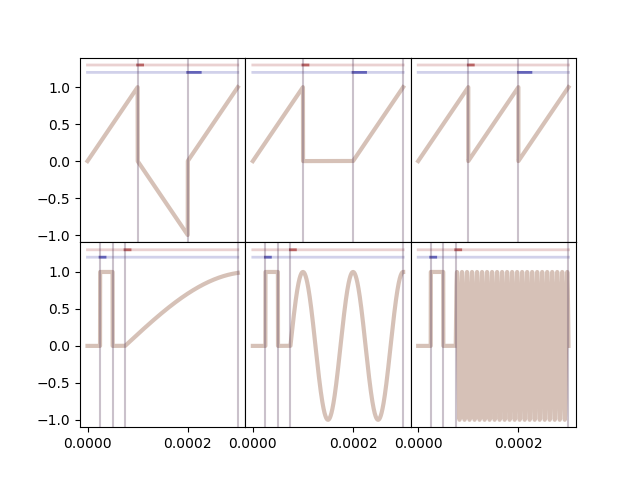

In [9]:
# Markers on both channels? That doesn't make sense. But which behaviour do we want?
seq.plotSequence()

In [10]:
(wfms, m1s, m2s, nreps, trig_waits, goto_states, jump_tos, channels) = tup
awg.make_send_and_load_awg_file([wfms[0], wfms[1]], m1s, m2s, nreps, trig_waits, goto_states, jump_tos, channels)

In [35]:
awg.close()
